# Perform a looping with the quadrotor

# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controller will be designed using an SQP solver.

Please submit your code as a runnable Jupyter Notebook.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [16]:
import quadrotor

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

Mass    = 0.5
Length  = 0.15
Inertia = 0.1
Dt      = 0.04
state size   = 6
control size = 2


## Part 1 - Setting up the trajectory Optimization (50 points)
1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)
2. We would like the quadrotor to perfom a looping. Find and implement a suitable cost function to perform a looping and add constraint to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP (levarging your code from Homework 2) with a large horizon to check that you can do a looping.
3. Show plots of all the states and controls of the robot as a function of time. Describe your design choices (in a concise manner) in the report.

### Compute the cost function:
    
$$
J = \frac{1}{2} \sum_{n=0}^{N} \left( (x_n - x_{\text{desired}})^\top Q (x_n - x_{\text{desired}}) + u_n^\top R u_n \right)
$$
   

In [17]:
import numpy as np
from scipy.linalg import block_diag

# def compute_cost(x, u, x_desired, Q, R, N):
#     cost = 0.0
#     for n in range(N + 1):
#         x_n = x[6*n : 6*(n+1)]
#         state_error = x_n - x_desired
#         cost += 0.5 * state_error.T @ Q @ state_error
#         if n < N:
#             u_n = u[2*n : 2*(n+1)]
#             cost += 0.5 * u_n.T @ R @ u_n
#     return cost

# def compute_cost(x, u, x_desired, time_division, Q, R, t1, t2, N):
#     """
#     Compute the cost function with dynamic desired states and handle np.nan entries.

#     Parameters:
#     - x (numpy.ndarray): Current state vector (size 6*(N+1),).
#     - u (numpy.ndarray): Current control inputs vector (size 2*N,).
#     - x_desired (numpy.ndarray): Desired states array (num_segments x 6).
#     - time_division (numpy.ndarray): Array defining the fraction of total time for each segment.
#     - Q (numpy.ndarray): State weighting matrix (6 x 6).
#     - R (numpy.ndarray): Control weighting matrix (2 x 2).
#     - N (int): Number of timesteps.

#     Returns:
#     - cost (float): Computed cost value.
#     """
#     cost = 0.0
#     cumulative_time = np.cumsum(time_division)

#     # state_error1 = (x[6*t1:6*t1+6] - np.nan_to_num(x_desired[0], nan=x[t1*6 : (t1+1)*6]))
#     # cost += 0.5 * (state_error1.T @ Q @ state_error1)
#     # state_error2 = (x[6*t2:6*t2+6] - np.nan_to_num(x_desired[1], nan=x[t2*6 : (t2+1)*6]))
#     # cost += 0.5 * (state_error2.T @ Q @ state_error2)
    
#     for n in range(N + 1):
#         # Determine the current time fraction
#         fraction = n / N

#         # Identify the current segment index
#         segment = np.searchsorted(cumulative_time, fraction, side='left')

#         # Retrieve the desired state for the current segment
#         # print("segment is ", segment)
#         x_d = x_desired[segment]

#         # Create a mask where desired state entries are not nan
#         mask = ~np.isnan(x_d)

#         # Compute the state error, ignoring variables with np.nan
#         state_error = x[n*6 : (n+1)*6] - x_d
#         state_error = state_error * mask  # Zero out errors where x_d is nan

#         # Accumulate the state cost
#         cost += 0.5 * state_error.T @ Q @ state_error
    
#     for n in range(N):
#         if n < N:
#             # Accumulate the control cost
#             u_n = u[2*n : 2*(n+1)]
#             cost += 0.5 * u_n.T @ R @ u_n
#     print("checking cost", np.isnan(cost).any())
#     return cost

def compute_cost(x, u, x_desired, time_division, Q, R, N, t=0, mpc_N=None):
    cost = 0.0
    for n in range(N + 1):
        x_n = x[6*n : 6*(n+1)]
        state_error = x_n - x_desired
        cost += 0.5 * state_error.T @ Q @ state_error
        if n < N:
            u_n = u[2*n : 2*(n+1)]
            cost += 0.5 * u_n.T @ R @ u_n
    return cost


In [18]:
def split_variables(x_guess, N):
    num_states = 6 * (N + 1)
    x = x_guess[:num_states]
    u = x_guess[num_states:]
    
    return x, u


### Compute the gradient of the cost function with respect to x and u:
    
$$
\nabla J = \begin{bmatrix}
Q (x_0 - x_{\text{desired}}) \\
Q (x_1 - x_{\text{desired}}) \\
\vdots \\
Q (x_N - x_{\text{desired}}) \\
R u_0 \\
R u_1 \\
\vdots \\
R u_{N-1} \\
\end{bmatrix}
$$

In [19]:

# def compute_gradient(x, u, x_desired, Q, R, N):
#     grad_x = np.zeros_like(x)
#     for n in range(N + 1):
#         x_n = x[6*n : 6*(n+1)]
#         state_error = x_n - x_desired
#         grad_x[6*n : 6*(n+1)] = Q @ state_error
    
#     grad_u = np.zeros_like(u)
#     for n in range(N):
#         u_n = u[2*n : 2*(n+1)]
#         grad_u[2*n : 2*(n+1)] = R @ u_n
    
#     grad = np.concatenate([grad_x, grad_u])
#     return grad

# def compute_gradient(x, u, x_desired, time_division, Q, R, t1, t2, N):
#     """
#     Compute the gradient of the cost function with dynamic desired states and handle np.nan entries.

#     Parameters:
#     - x (numpy.ndarray): Current state vector (size 6*(N+1),).
#     - u (numpy.ndarray): Current control inputs vector (size 2*N,).
#     - x_desired (numpy.ndarray): Desired states array (num_segments x 6).
#     - time_division (numpy.ndarray): Array defining the fraction of total time for each segment.
#     - Q (numpy.ndarray): State weighting matrix (6 x 6).
#     - R (numpy.ndarray): Control weighting matrix (2 x 2).
#     - N (int): Number of timesteps.

#     Returns:
#     - grad (numpy.ndarray): Gradient vector (size 6*(N+1) + 2*N,).
#     """
#     grad_x = np.zeros_like(x)
#     grad_u = np.zeros_like(u)
#     cumulative_time = np.cumsum(time_division)

#     # grad_x[6*t1: 6*t1+6] = Q @ (x[6*t1: 6*t1+6] - np.nan_to_num(x_desired[0], nan=x[t1*6 : (t1+1)*6]))
#     # grad_x[6*t2: 6*t2+6] = Q @ (x[6*t2: 6*t2+6] - np.nan_to_num(x_desired[1], nan=x[t2*6 : (t2+1)*6]))
    
#     for n in range(N + 1):
#         # Determine the current time fraction
#         fraction = n / N

#         # Identify the current segment index
#         segment = np.searchsorted(cumulative_time, fraction, side='left')

#         # Retrieve the desired state for the current segment
#         x_d = x_desired[segment]

#         # Create a mask where desired state entries are not nan
#         mask = ~np.isnan(x_d)

#         # Compute the state error, ignoring variables with np.nan
#         state_error = (x[n*6 : (n+1)*6] - np.nan_to_num(x_d, nan=x[n*6 : (n+1)*6]))
        
#         # Accumulate the gradient for states
#         grad_x[n*6 : (n+1)*6] = Q @ state_error

#     # print("checking nan for grad1", np.isnan(grad).any())
#     for n in range(N):
#         # Accumulate the gradient for controls
#         u_n = u[2*n : 2*(n+1)]
#         grad_u[2*n : 2*(n+1)] = R @ u_n

#     # Concatenate state and control gradients
#     grad = np.concatenate([grad_x, grad_u])
#     print("checking nan for grad", np.isnan(grad).any())
#     return grad

def compute_gradient(x, u, x_desired, time_division, Q, R, N, t=0, mpc_N=None):
    grad_x = np.zeros_like(x)
    for n in range(N + 1):
        x_n = x[6*n : 6*(n+1)]
        state_error = x_n - x_desired
        grad_x[6*n : 6*(n+1)] = Q @ state_error
    
    grad_u = np.zeros_like(u)
    for n in range(N):
        u_n = u[2*n : 2*(n+1)]
        grad_u[2*n : 2*(n+1)] = R @ u_n
    
    grad = np.concatenate([grad_x, grad_u])
    return grad


### Compute the Hessian matrix of the cost function:
    
$$
H = \frac{1}{2} \begin{bmatrix}
Q & 0 & \cdots & 0 & 0 & \cdots & 0 \\
0 & Q & \cdots & 0 & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & Q & 0 & \cdots & 0 \\
0 & 0 & \cdots & 0 & R & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 0 & 0 & \cdots & R \\
\end{bmatrix}
$$


In [20]:

def compute_hessian(Q, R, N):
    Q_blocks = [Q for _ in range(N + 1)]
    R_blocks = [R for _ in range(N)]
    H = block_diag(*Q_blocks, *R_blocks)
    return H


### Compute the constraints for the Quadrotor SQP problem.

The constraints ensure that the discretized dynamics are satisfied
and that the initial state matches the desired initial conditions.

Mathematically, for each timestep n = 0 to N-1:
$$
p_{x, n+1} = p_{x, n} + dt \cdot v_{x, n} \\
v_{x, n+1} = v_{x, n} + dt \cdot \left( - \frac{(u_{1, n} + u_{2, n}) \cdot \sin(\theta_n)}{m} \right) \\
p_{y, n+1} = p_{y, n} + dt \cdot v_{y, n} \\
v_{y, n+1} = v_{y, n} + dt \cdot \left( \frac{(u_{1, n} + u_{2, n}) \cdot \cos(\theta_n)}{m} - g \right) \\
\theta_{n+1} = \theta_n + dt \cdot \omega_n \\
\omega_{n+1} = \omega_n + dt \cdot \left( \frac{r \cdot (u_{1, n} - u_{2, n})}{I} \right)
$$

Additionally, initial conditions are enforced:
    x0 = [p_x_init, v_x_init, p_y_init, v_y_init, theta_init, omega_init]

In [21]:
from scipy.linalg import block_diag
from scipy import sparse

def compute_constraints(x, u):
    m = quadrotor.MASS
    I = quadrotor.INERTIA
    r = quadrotor.LENGTH
    g = quadrotor.GRAVITY_CONSTANT
    N = u.shape[0] // 2  # Number of timesteps
    dt = quadrotor.DT

    num_states = 6 * (N + 1)
    num_controls = 2 * N
    num_constraints = 6 * N + 6  # 6 constraints per timestep + 6 initial conditions

    G = np.zeros((num_constraints, num_states + num_controls))
    g_vec = np.zeros(num_constraints)

    for n in range(N):
        # Indices for state variables
        idx_pxn = 6 * n
        idx_vxn = 6 * n + 1
        idx_pyn = 6 * n + 2
        idx_vyn = 6 * n + 3
        idx_thetan = 6 * n + 4
        idx_omegan = 6 * n + 5

        idx_pxn1 = 6 * (n + 1)
        idx_vxn1 = 6 * (n + 1) + 1
        idx_pyn1 = 6 * (n + 1) + 2
        idx_vyn1 = 6 * (n + 1) + 3
        idx_thetan1 = 6 * (n + 1) + 4
        idx_omegan1 = 6 * (n + 1) + 5

        # Indices for control inputs
        idx_u1n = 6 * (N + 1) + 2 * n
        idx_u2n = 6 * (N + 1) + 2 * n + 1

        # Extract state variables
        p_xn = x[idx_pxn]
        v_xn = x[idx_vxn]
        p_yn = x[idx_pyn]
        v_yn = x[idx_vyn]
        thetan = x[idx_thetan]
        omegan = x[idx_omegan]

        # Extract control inputs
        u1n = u[2 * n]
        u2n = u[2 * n + 1]

        # Constraint 1: p_x_{n+1} - p_xn - dt * v_xn = 0
        G[6 * n, idx_pxn1] = 1
        G[6 * n, idx_pxn] = -1
        G[6 * n, idx_vxn] = -dt
        G[6 * n, 6 * (N + 1) + 2 * n: 6 * (N + 1) + 2 * n + 2] = 0  # No u involved
        g_vec[6 * n] = x[idx_pxn1] - p_xn - dt * v_xn

        # Constraint 2: v_x_{n+1} - v_xn - dt * ( - (u1n + u2n) * sin(thetan) / m ) = 0
        G[6 * n + 1, idx_vxn1] = 1
        G[6 * n + 1, idx_vxn] = -1
        G[6 * n + 1, idx_thetan] = dt * (u1n + u2n) * np.cos(thetan) / m
        G[6 * n + 1, num_states + 2 * n] = dt * np.sin(thetan) / m
        G[6 * n + 1, num_states + 2 * n + 1] = dt * np.sin(thetan) / m
        g_vec[6 * n + 1] = x[idx_vxn1] - v_xn - dt * (- (u1n + u2n) * np.sin(thetan) / m)

        # Constraint 3: p_y_{n+1} - p_yn - dt * v_yn = 0
        G[6 * n + 2, idx_pyn1] = 1
        G[6 * n + 2, idx_pyn] = -1
        G[6 * n + 2, idx_vyn] = -dt
        g_vec[6 * n + 2] = x[idx_pyn1] - p_yn - dt * v_yn

        # Constraint 4: v_y_{n+1} - v_yn - dt * ( (u1n + u2n) * cos(thetan) / m - g ) = 0
        G[6 * n + 3, idx_vyn1] = 1
        G[6 * n + 3, idx_vyn] = -1
        G[6 * n + 3, idx_thetan] = -dt * (u1n + u2n) * (-np.sin(thetan)) / m
        G[6 * n + 3, num_states + 2 * n] = -dt * np.cos(thetan) / m
        G[6 * n + 3, num_states + 2 * n + 1] = -dt * np.cos(thetan) / m
        g_vec[6 * n + 3] = x[idx_vyn1] - v_yn - dt * ( (u1n + u2n) * np.cos(thetan) / m - g )

        # Constraint 5: theta_{n+1} - thetan - dt * omegan = 0
        G[6 * n + 4, idx_thetan1] = 1
        G[6 * n + 4, idx_thetan] = -1
        G[6 * n + 4, idx_omegan] = -dt
        g_vec[6 * n + 4] = x[idx_thetan1] - thetan - dt * omegan

        # Constraint 6: omega_{n+1} - omegan - dt * ( r * (u1n - u2n) / I ) = 0
        G[6 * n + 5, idx_omegan1] = 1
        G[6 * n + 5, idx_omegan] = -1
        G[6 * n + 5, num_states + 2 * n] = -dt * r / I
        G[6 * n + 5, num_states + 2 * n + 1] = dt * r / I
        g_vec[6 * n + 5] = x[idx_omegan1] - omegan - dt * ( r * (u1n - u2n) / I )

    # Initial Conditions Constraints
    # Constraint 7: p_x0 - p_x_init = 0
    G[-6, 0] = 1
    # g_vec[-6] = x[0]

    # Constraint 8: v_x0 - v_x_init = 0
    G[-5, 1] = 1
    # g_vec[-5] = x[1]

    # Constraint 9: p_y0 - p_y_init = 0
    G[-4, 2] = 1
    # g_vec[-4] = x[2]

    # Constraint 10: v_y0 - v_y_init = 0
    G[-3, 3] = 1
    # g_vec[-3] = x[3]

    # Constraint 11: theta0 - theta_init = 0
    G[-2, 4] = 1
    # g_vec[-2] = x[4]

    # Constraint 12: omega0 - omega_init = 0
    G[-1, 5] = 1
    # g_vec[-1] = x[5]

    return G, g_vec

### Solve the Karush-Kuhn-Tucker (KKT) conditions for the Quadrotor optimization problem.

The KKT system is defined as:

$$
\begin{bmatrix}
H & G^\top \\
G & 0
\end{bmatrix}
\begin{bmatrix}
\delta x \\
\delta \lambda
\end{bmatrix}
=
\begin{bmatrix}
-\nabla J \\
-\mathbf{g}_{\text{vec}}
\end{bmatrix}
$$


In [22]:
from scipy.sparse import bmat, csc_matrix, eye
from scipy.sparse.linalg import spsolve

# Without inequality handling
def solve_kkt(H, grad_J, G, g_vec, epsilon=1e-6):
    """
    Solve the KKT system using sparse matrices.
    """
    D = H.shape[0]  # Number of decision variables
    C = G.shape[0]  # Number of constraints

    # Convert H to sparse if it isn't already
    if not isinstance(H, csc_matrix):
        H = csc_matrix(H)

    # Convert G to sparse if it isn't already
    if not isinstance(G, csc_matrix):
        G = csc_matrix(G)

    # Construct the sparse KKT matrix using block matrices
    KKT_matrix = bmat([
        [H, G.T],
        [G, None]
    ], format="csc")

    # Construct the RHS vector
    rhs = -np.concatenate([grad_J, g_vec])

    try:
        # Solve the sparse KKT system
        solution = spsolve(KKT_matrix, rhs)
    except Exception:
        # If the KKT matrix is singular, add regularization to H
        H += epsilon * eye(H.shape[0], format="csc")
        KKT_matrix = bmat([
            [H, G.T],
            [G, None]
        ], format="csc")
        try:
            solution = spsolve(KKT_matrix, rhs)
        except Exception as e:
            raise ValueError("KKT system is singular and cannot be solved.") from e

    # Extract delta_x and delta_lambda
    delta_x = solution[:D]
    next_lambda = solution[D:]

    return delta_x, next_lambda


In [23]:
import numpy as np
import osqp
from scipy import sparse
from qpsolvers import solve_problem, Problem

def solve_kkt_qp(H, grad_J, G, g_vec, lb, ub):
    """
    Solve the KKT system using OSQP with inequality constraints (variable bounds).
    
    Parameters:
    - H: Hessian matrix (D x D), should be symmetric positive semidefinite
    - grad_J: Gradient vector (D,)
    - G: Equality constraint matrix (C x D)
    - g_vec: Equality constraint residuals (C,)
    - lb: Lower bounds for variables (D,)
    - ub: Upper bounds for variables (D,)
    
    Returns:
    - delta_z: Primal variable updates (D,)
    - delta_lambda: Dual variable updates for equality constraints (C,)
    """
    D = H.shape[0]  # Number of decision variables
    C = G.shape[0]  # Number of equality constraints
    
    # Define P (Hessian) and ensure it is in CSC format
    epsilon = 1e-6
    H += epsilon * sparse.eye(H.shape[0], format='csc')
    P = sparse.csc_matrix(H)
    
    # Define q
    q = grad_J
    
    # Define A matrix by stacking G and identity for variable bounds
    A_eq = sparse.csc_matrix(G)
    A_var = sparse.eye(D, format='csc')
    A = sparse.vstack([A_eq, A_var], format='csc')
    
    # Define lower and upper bounds for constraints
    # For equality constraints: A_eq x = g_vec
    # For variable bounds: lb <= x <= ub
    # So, l = [g_vec; lb]
    #      u = [g_vec; ub]
    l = np.concatenate([-g_vec, lb])
    u = np.concatenate([-g_vec, ub])
    
    # Setup OSQP problem
    prob = osqp.OSQP()
    prob.setup(P=P, q=q, A=A, l=l, u=u, verbose=True)
    
    # Solve the problem
    res = prob.solve()
    print(res.info.status)
    if res.info.status_val not in [osqp.constant('OSQP_SOLVED'), osqp.constant('OSQP_SOLVED_INACCURATE')]:
        print("using alternative")
        problem = Problem(P, q, np.zeros(D), np.array([np.inf]), G, -g_vec, lb, ub)
        solution = solve_problem(problem, solver="cvxopt")
        return solution[:D], solution[D:]
        raise ValueError(f"OSQP did not solve the problem! Status: {res.info.status}")
    
    # Extract the solution
    delta_z = res.x[:D]
    next_lambda = res.x[D:D+C]
    
    return delta_z, next_lambda


### Compute the total constraint violation.

The violation includes:
- Sum of absolute values of equality constraint residuals.
- Sum of violations for state and control variables exceeding their bounds.



In [24]:

def compute_constraint_violation(g_vec, x_vec=None, bounds=None):
    violation = np.sum(np.abs(g_vec))
    
    if x_vec is not None and bounds is not None:
        upper_bounds = bounds.get('upper', np.full_like(x_vec, np.inf))
        lower_bounds = bounds.get('lower', np.full_like(x_vec, -np.inf))
        
        violations_above = np.maximum(x_vec - upper_bounds, 0)
        violations_below = np.maximum(lower_bounds - x_vec, 0)
        violation += np.sum(violations_above + violations_below)
    
    return violation

### 

###


In [25]:

def check_convergence(grad_L, g_vec, tol=1e-4):
    optimality = np.linalg.norm(grad_L, np.inf)
    feasibility = np.linalg.norm(g_vec, np.inf)
    return optimality < tol and feasibility < tol

import quadrotor
import matplotlib.pyplot as plt

def plot_results(states_opt, controls_opt, cost_history, constraint_violation_history, alpha_history, N):
    """
    Plot the optimized state trajectories, control inputs, and optimization history.

    Parameters:
    - states_opt: Optimized state variables dictionary
    - controls_opt: Optimized control inputs array
    - cost_history: List of cost values over iterations
    - constraint_violation_history: List of constraint violations over iterations
    - alpha_history: List of step sizes used in line search over iterations
    - N: Number of timesteps
    """
    timesteps = np.arange(N + 1) * quadrotor.DT  # Assuming dt=0.01

    plt.figure(figsize=(18, 12))

    ind_p_x, ind_v_x, ind_p_y, ind_v_y, ind_theta, ind_omega = range(6)
    # Plot Positions
    plt.subplot(3, 2, 1)
    plt.plot(timesteps, states_opt[ind_p_x::6], label='p_x')
    plt.plot(timesteps, states_opt[ind_p_y::6], label='p_y')
    plt.title('Position Trajectories')
    plt.xlabel('Time [s]')
    plt.ylabel('Position [m]')
    plt.legend()
    plt.grid(True)

    # Plot Velocities
    plt.subplot(3, 2, 2)
    plt.plot(timesteps, states_opt[ind_v_x::6], label='v_x')
    plt.plot(timesteps, states_opt[ind_v_y::6], label='v_y')
    plt.title('Velocity Trajectories')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity [m/s]')
    plt.legend()
    plt.grid(True)

    # Plot Orientation
    plt.subplot(3, 2, 3)
    plt.plot(timesteps, states_opt[ind_theta::6], label='theta')
    plt.title('Orientation Trajectory')
    plt.xlabel('Time [s]')
    plt.ylabel('Theta [rad]')
    plt.legend()
    plt.grid(True)

    # Plot Angular Velocity
    plt.subplot(3, 2, 4)
    plt.plot(timesteps, states_opt[ind_omega::6], label='omega')
    plt.title('Angular Velocity Trajectory')
    plt.xlabel('Time [s]')
    plt.ylabel('Omega [rad/s]')
    plt.legend()
    plt.grid(True)

    # Plot Control Inputs
    control_timesteps = np.arange(N) * 0.01 + 0.005  # Center of timestep
    plt.subplot(3, 2, 5)
    plt.step(control_timesteps, controls_opt[0::2], where='mid', label='u1')
    plt.step(control_timesteps, controls_opt[1::2], where='mid', label='u2')
    plt.title('Control Inputs')
    plt.xlabel('Time [s]')
    plt.ylabel('Control Input [N]')
    plt.legend()
    plt.grid(True)

    # Plot Cost and Constraint Violation History
    plt.subplot(3, 2, 6)
    iterations = np.arange(1, len(cost_history) + 1)
    plt.plot(iterations, cost_history, label='Cost')
    plt.plot(iterations, constraint_violation_history, label='Constraint Violation')
    plt.title('Optimization History')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


### Integrated sqp solver

In [ ]:
import matplotlib.pyplot as plt
# Parameters

N = 100
dt = quadrotor.DT
max_iter = 100
tol = 1e-4

# Physical and initial parameters
params = {
    'm': quadrotor.MASS,          # mass (kg)
    'I': quadrotor.INERTIA,          # moment of inertia (kg·m²)
    'r': quadrotor.LENGTH,         # distance to propellers (m)
    'g': quadrotor.GRAVITY_CONSTANT,      # gravitational constant (m/s²)
    'p_x_init': 0.0,   # initial p_x
    'v_x_init': 0.0,   # initial v_x
    'p_y_init': 0.0,   # initial p_y
    'v_y_init': 0.0,   # initial v_y
    'theta_init': 0.0, # initial theta
    'omega_init': 0.0, # initial omega
    'N': N             # Number of timesteps
}

# Desired state

# If just using two segments
# time_division = np.array([0.5, 0.5])
# x_desired = np.array([
#                     # [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
#                     #   [0.0, 0.0, 2.0, 0.0, np.pi, np.nan],
#                       [0.0, np.nan, 3.0, np.nan, np.pi, np.nan],
#                     #   [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
#                     #   [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
#                       [0.0, 0.0, 0.0, 0.0, 2*np.pi, 0.0]
#                       ])

# If using four segments
time_division = np.array([0.4, 0.1, 0.4, 0.1])
t1 = 25
t2 = 50
# x_desired = np.array([
#                     [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
#                     [0.0, np.nan, 2.0, np.nan, np.pi, np.nan], # Why is that if I add np.pi it will behave weirdly
#                     [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
#                     [0.0, np.nan, 0.0, 0.0, 2*np.pi, np.nan]
#                     ])

x_desired = np.array(
                    [0.0, 0.0, 3.0, 0.0, np.pi, 0.0]
                    )
# time_division = np.array([0.25, 0.25, 0.25, 0.25])
# x_desired = np.array([[2.0, 0.0, 2, 0.0, np.nan, np.nan],
#                       [0.0, 0.0, 4.0, 0.0, np.pi, np.nan],
#                       [-2.0, 0.0, 2, 0.0, np.nan, np.nan],
#                       [0.0, 0.0, 0.0, 0.0, 2*np.pi, np.nan]])

# Weighting matrices
Q = np.diag([10, 1, 16, 12, 20, 5])
Q = np.diag([10, 1, 10, 1, 10, 1])
# R = np.eye(2)
R = np.diag([1, 1])

# Initialize decision variables: [x0, x1, ..., xN, u0, u1, ..., uN-1]
num_states = 6 * (N + 1)
num_controls = 2 * N
z_guess = np.zeros(num_states + num_controls)

# Set initial state in z_guess
z_guess[0] = params['p_x_init']
z_guess[1] = params['v_x_init']
z_guess[2] = params['p_y_init']
z_guess[3] = params['v_y_init']
z_guess[4] = params['theta_init']
z_guess[5] = params['omega_init']
# The rest of z_guess are initialized to zero (x1, v1, ..., u0, u1, ...)

# Initialize Lagrange multipliers
num_constraints = 6 * N + 6  # 6 constraints per timestep + 6 initial conditions
lambda_vec = np.zeros(num_constraints)

# Define bounds for all decision variables
bounds = {
    'upper': np.array([np.inf, np.inf, np.inf, np.inf, np.inf, np.inf] * (N + 1) + [10.0, 10.0] * N),
    'lower': np.array([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf] * (N + 1) + [0.0, 0.0] * N)
}

# Compute initial cost
states_initial, controls_initial = split_variables(z_guess, N)
f_best = compute_cost(states_initial, controls_initial, x_desired, time_division, Q, R, t1, t2, N)

# Compute initial constraints
G_initial, g_vec_initial = compute_constraints(states_initial, controls_initial)

# Compute initial constraint violation
g_best = compute_constraint_violation(g_vec_initial, z_guess, bounds)

# History tracking for plotting
cost_history = []
constraint_violation_history = []
alpha_history = []

for iteration in range(1, max_iter + 1):
    # Split variables
    states_current, controls_current = split_variables(z_guess, N)

    # Compute gradient
    grad_J = compute_gradient(states_current, controls_current, x_desired, time_division, Q, R, t1, t2, N)

    # Compute Hessian
    H = compute_hessian(Q, R, N)

    # Compute constraints
    G, g = compute_constraints(states_current, controls_current)

    delta_z, delta_lambda = solve_kkt_qp(H, grad_J, G, g, bounds['lower']-z_guess, bounds['upper']-z_guess)
    print("shape of delta_z", delta_z.shape)
    print("shape of guess", z_guess.shape)

    # Update decision variables
    z_trial = z_guess + delta_z

    # Compute new cost and constraint violation
    states_trial, controls_trial = split_variables(z_trial, N)
    f_trial = compute_cost(states_trial, controls_trial, x_desired, time_division, Q, R, t1, t2, N)
    G_trial, g_vec_trial = compute_constraints(states_trial, controls_trial)
    g_trial_violation = compute_constraint_violation(g_vec_trial, z_trial, bounds)

    # Update best cost and constraint violation
    if f_trial < f_best:
        f_best = f_trial
    if g_trial_violation < g_best:
        g_best = g_trial_violation

    # Update history
    cost_history.append(f_trial)
    constraint_violation_history.append(g_trial_violation)
    alpha_history.append(1.0)  # Placeholder, as step size is fixed here

    # Update current guess
    z_guess = z_trial.copy()

    # Logging
    print(f"Iteration {iteration}: Cost = {f_trial:.3f}, Constraint Violation = {g_trial_violation:.3f}")

    # Check for convergence
    grad_L = grad_J  # Since OSQP handles dual variables internally
    if check_convergence(grad_L, g, tol):
        print(f"Converged in {iteration} iterations.")
        break

else:
    print(f"Reached maximum iterations ({max_iter}) without full convergence.")

# After optimization, split the optimized variables
states_opt, controls_opt = split_variables(z_guess, N)



-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 806, constraints m = 1412
          nnz(P) + nnz(A) = 3518
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.9605e+03   2.31e+00   4.04e+03   1.00e-01   8.36e-04s
  25  -2.7091e+02   8.80e-04   1.91e-02   1.00e-01   1.36e-03s

status:               solved
number of ite

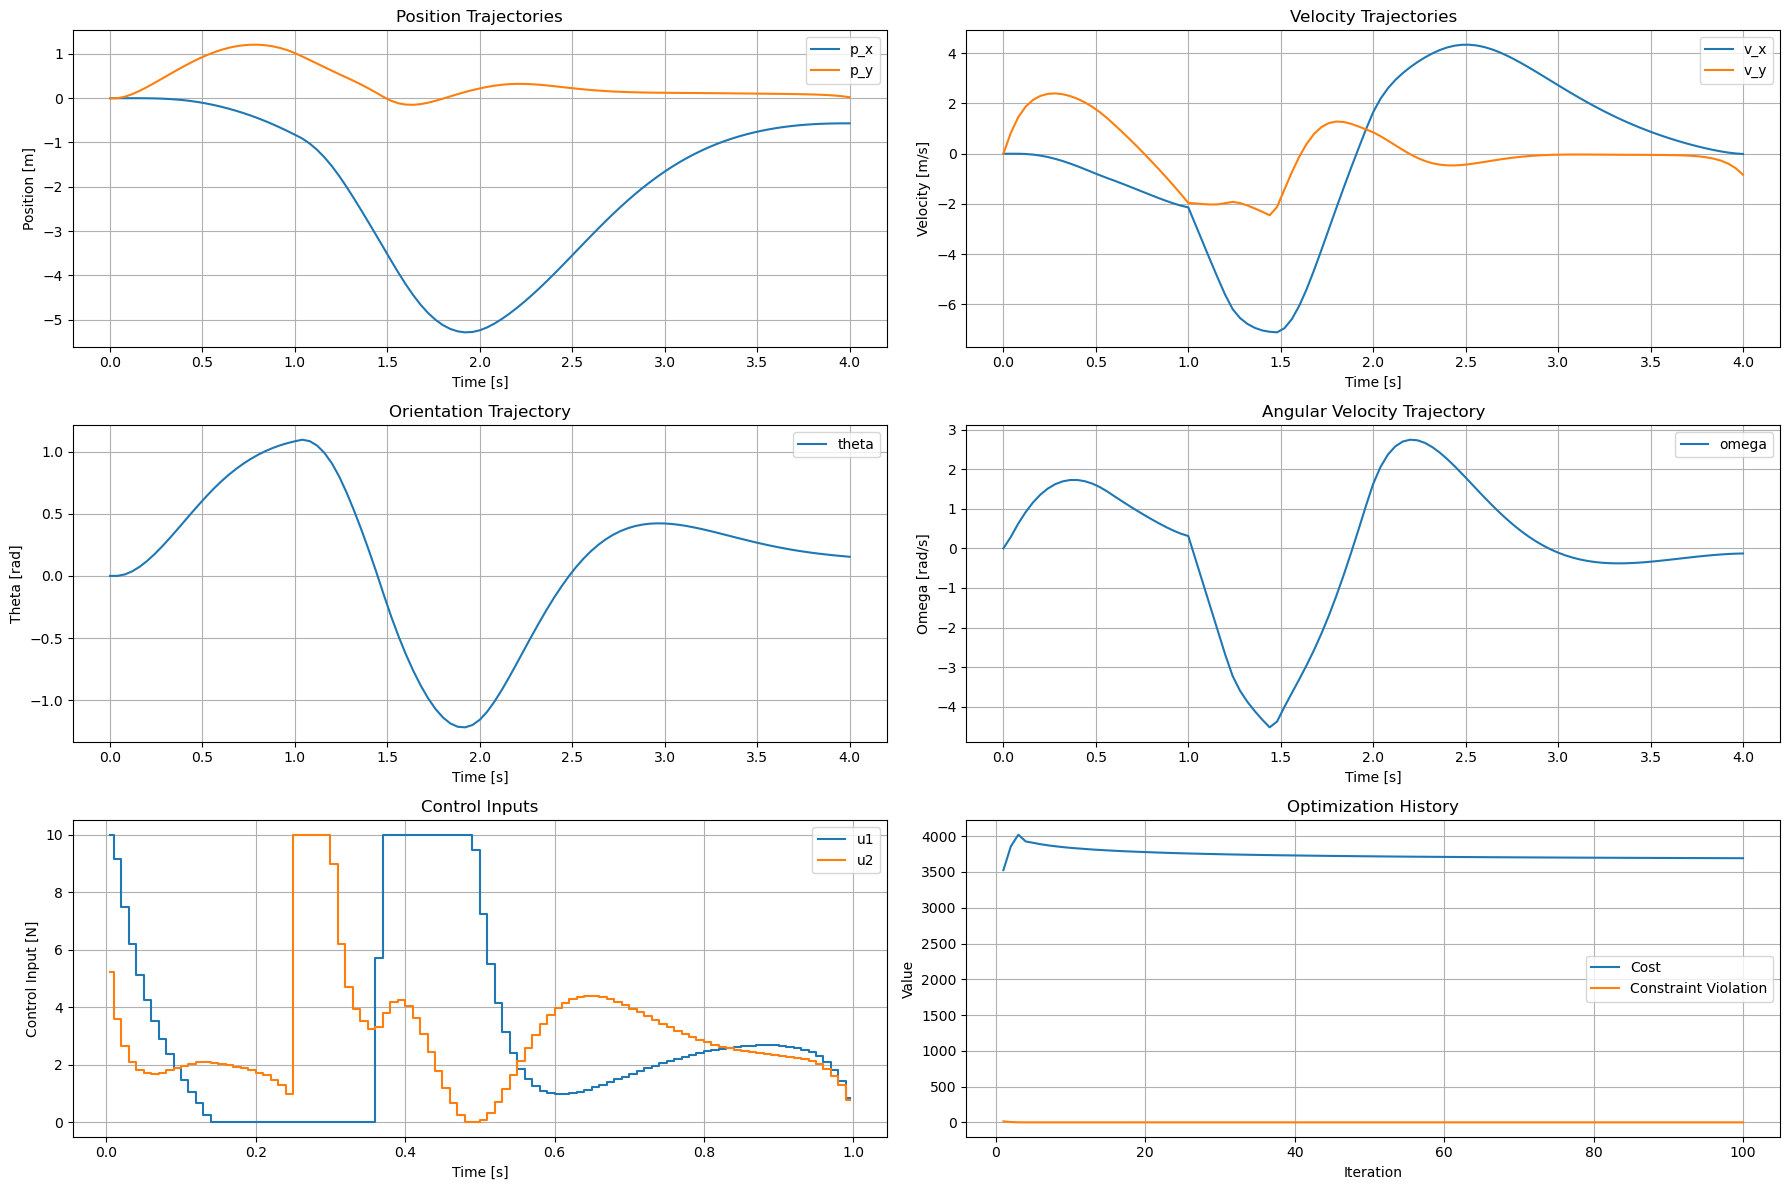

In [27]:

# Plotting the results
plot_results(states_opt, controls_opt, cost_history, constraint_violation_history, alpha_history, N)


In [28]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython

# def controller(x, t):
#     return np.zeros(2)

x_init = np.array([0, 0, 0., 0 ,0, 0])
horizon_length = 100
# t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)
u = np.zeros((2, controls_opt.shape[0] // 2))
state = np.zeros((6, states_opt.shape[0] // 6))
u[0, :] = controls_opt[::2]
u[1, :] = controls_opt[1::2]
state[0, :] = states_opt[::6]
state[1, :] = states_opt[1::6]
state[2, :] = states_opt[2::6]
state[3, :] = states_opt[3::6]
state[4, :] = states_opt[4::6]
state[5, :] = states_opt[5::6]
print("state shape", state.shape)
print("u shape", u.shape)

quadrotor.animate_robot(state, u)

state shape (6, 101)
u shape (2, 100)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAWeBtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI3
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
Ea9liIQAN//+9vD+BTY7mNCXEc3onTMfvxW4ujQ3vc4AAAMAAAMAAAMAADSY0H4zd2rDhiAAAAMA
JgAGCANgAzAEdwBJhifrPwALwRFkBJwPzJUmFGT2qHXo4m6RCitIlhRYet3pioe7PtHMnO4JkntJ
ujXVK9mpvpov1Dq5CrLp26+E/qiy2XJ1DXbFQFIeD6dj4d/Ycg4MlRjSj5F/jO4dneZbKchBkxER
1+dwaLseoQTUOIHe+AjMd/01j3lkHunyumHGATF5QfuGMNEhmAiiUAYOIeHxFiIgg2yx/sREsJlD
kHggnz8ibjDHy6sod15ejTD7nM3nSKn356x7NU+rLjiy+TGV7zlKZBPivMIavE++a9A0lqsJYdgr
ySjKMHT/BXnDAgmDXfO64jpiyGPFAqtkFWJ5TEQleZ1J5ApIiAbrmpifDenz7+L/Amzw77yl2Tw8
dV/vzdPNgHyNMPd7Qeurp1KvON9Kpiiq9WLcXgAu6rO4VJF3rAEt8s69kj217dTvtZESV+cTFtXm
3MWiO6d6NaNes2ZxjPgWoV3pWkje1mKUkGtlApOFiP89izn4l4W4+hf3LyzVN51uNpUvVYypDS+g
pC1LnZTRKKLkhiARCz8vUNE2jmd9LBuop4wtHxWyQ+hIDVe6n4Pcoo/9RyuTt19uWVECJXQ5P2rb
xI5GlCWiJMavXMOUuYlJBrvhIWmp7Grh1AuEuWsSZb82qwUX4YpLA+jhMqj8m793/30LpXeFCUvZ
2UCe1W6p2YBPju3XCRbv1SUWh+PCzX/y/JOTn5daKAGqplfjh5srEeY/c4vSTRR95J8M5n4/TGcA
xLQ3PrLHc2GMPnZEJfxoC+wBYhBAypi/Fy9xMI1ucvHymIu5d422tynfquHUyrPs+EoGJWAKSh7s
A/1MVNHQEZn8PVx0E7zdACzSSpOOGTWhaF57lTZmwv25AAm1RWpQZQNAjDBwssbGzn7T9AUYvB5T
ROC2Y81b4lVRo85K9ALdVT88zTm3NQJtghKkRdRSpqhUtIrjCZKMykOlm2t9EO0rQF5ZuCfH/lz+
/UwWvmDPTn9cTK5z3Vxl7LtLEbhh5Vfx71ieysrD8L/9IQmf+q2zFJh7Sh+8YpRuqdP1EIbAeOEu
GIyXAZ8dExE3ggS3C04yJjAgtHFPfwoCk4e5VyD1+YVxVKaQ+yeMF6HGK7M7BdG0++ViQSUecZkc
yq1tCyReJ2zQBZtiL+Q3loxtWdewSaQ+NnVN7fG8qziVfQ55Fst86EHRbfp6enX6l609SVLqc8hc
xf/fCQwUA3xUgn9ALzX/KIqIs204slWYN4Bk3i0PMdv4mAPQ3kYPhLZ2GJFrqmMsOmKKc+fGkIXi
CsZIoKF5Reli6qIvktB/sjAAAAMAAAkWyMDgiQ3CAAY8D5b4p8f/bpMk/gAAAwG3Qyt8/mo9yspk
RfodVLqIZsSoWR9mJ+ZStFs0nC9lho0wf3pE3ctEI+r9FcbMZfSEUi4TzLjsOJaNIfRstS+e+36K
xRSkcYoc+pM8evwS6OIosmL9oY3WzfFooOcbWi5r8zddCofBSiaZWbWN6zV9bIs+xmxMSuFIOdOG
NyL0qshvq6dzSGAcoHUAWPXxR4a5/olUhDQyVadvTe9bbnAGxpNiFZwvI0HQqdq+uCGfPVOAfGK4
m5JFfq0x/kxgoCTxNGeMVjuFrHsVNLshI7h9uGU1A4hMrh0fPAIwM6nWvGEABM4QMgjUK/HiRool
GouB+6C87l9PZYzIeqwe+Z3fqsxghKM/NL9yzpTBF2F8daxRaUvxCLtesiJQSO3U0wZAYizEZYwq
CmH5Ck5nJ51IvAm9HcnUEXfmRwM/+WLW4O+MLOy3Gxh/XaeKMEzd8Y6Irn5NNim4QvpJrLn/1LeP
lX9fycxcMAAVIAAAVb2xfwCfB9E3WAar/bEzPZDP9fgAAAMBw8Zory57THTeLnWalqKoKkldPLcy
Q6q90POHBTC+/4VaXs2NdVuCQk8Z/Rf86/6P5NgOAkt5wOAQ5QTmy+ko2gWW21TgARpNHOi9aReo
A9LJ2gCX2eXo9z8ds3DZ/Gv3fD3VBrSJBTwvd9z8Dh2MwW+pKGCR/QtFnVzWmxBwz0k8zIQ3socB
OtEI3sVGVTGAf0SgvDUoIVFbeawkd+f75yUFBS4Hn2YRvzn26kTNFywZOwmvyTqrYNFvjqsE4Wcn
g3/E1qd5ui3gfCQHBhyXuTkrUh8v6TwYuYhOJH1okhSUTRBVhfdRBIe3KU7VIoBLddiI9VeMvc09
aFZTpscipY8/9hBn6Nfl8wJHepwirKCCpS0kHMfjIvsNp8ja8RNBQXezD6hmnUR6B3ycCNcY8h9z
4ULZNojiVcAZu9GHtp9TwOnCmjVhpQkt0k7myFRHNygNkEYliFUAn32fIJMk4YMiV/zBsVgWUVNY
ZfVzd8p9taL7Y5jXrS1ZD01kU3jt7UqYw6oQms+dOAlmQv4ybpCxgY6l/55FoGZlrpSPWf6Y5M2n
RewtSTLJU0xa84e0zRCKgP6ySjan4kv5+W6FHdlbqFTeODHx5FLE/3zN/JZyIeaWvABvBF5zpgug
foydEDkjHU18k+M0aGe8ROzpijk7csbo+VaUO162cLMZyU4Yb25xTXMGgz9FvVT6D891IxM7BlUk
FqQdeIbf4LhDAKDciZCnyxBKs++2OyaXFMTxVbgHqCeA3NQ2ykyFMxtNG/bagRrRfKJqUIPVItej
lJZanpr1aK9b6oJclPsPMF18d9e1MlEeWnl5GHG17rmElEG5KaH6OSC8TdEpo3s0+ThxJaRqRj4W
YkcIAAADAAN9xddnfiouYclNoMUEzLfSbRl9kuLQw/n6zhz4QmkeQV3btfS34MWi/JsNUoMv+8ZZ
gyoH/20I3Rf8FrhV6PaqL

In [29]:
import numpy as np

arr = np.array([1, 2, 3, 4, 5, 6])

# Reshape into a 2x3 array
new_arr = arr.reshape(2, 3)

print(new_arr)

[[1 2 3]
 [4 5 6]]






## Part 2 - Model predictive control (MPC) (50 points)
1. Use the trajectory optimization method from Part I to design a MPC controller and test it using the simulator below. In particular, verify that it can handle perturbations by calling the ```quadrotor.simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state anc control evolution.
2. Explain your intended design in the report, including the cost function and found control law

The ```quadrotor.simulate``` function takes as an input an initial state, a controller, the number of discrete time steps and a boolean value to indicate the presence of perturbation. The controller has to be a function taking as an input a state and time index and outputting a control vector.

To visualize the trajectory, use the ```quadrotor.animate_robot``` function
and show the animation (show the plots in your report).

## Bonus (10 points)
Add a state constraint to perform the looping while maintening a positive altitude. Use the origin as an initial state.

In [30]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython

def controller(x, t):
    N = 20
    
    return 

x_init = np.array([0, 0, 0., 0 ,0, 0])
horizon_length = 100
t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)
quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAI3JtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI3
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
ERdliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/9/791p1zzw78KA2BJ
aqh8Cisz4sCaS273do3rE6Y/JhWMUQsmEaRU/Ij0ewp43OMPz7R2SPbm+68q6yIkr84mLavcb4tE
d070a0b9ZszjGfAtQrvRD1G9rMUpINbKBScMWSKQeGKtaBeKcnHj2ruzx+/FvasfiGthZyqryFyf
SymiUUXJDEAiFn5eoaJtHQX6WDdRTxhaPivuPNoGWRgOt4e5RR/7Yz9OD1wVnmIEin6d0/2n7ff5
QkudR2W5WhNcyFXOyrd97UA32NXDqBcJctX9U46kttH/DFJYH0hyX6vQT2C/q5r93/30LoXeFCUv
Z2UCm1QQEwWd7g6R8abZGdDHEQd4Wa/+X5Jyc/TuQ2tfAcRZiMNzOx5j9zi9JNFH3knoG9cPfXyA
WvVWp1qE8A+Wwxh87IhL7bp3FYF1ThTBCvrksq2XuJhGtzmL96zLuYDvavcqtPa8cv2zlZ81B2dw
gWFFsYA00vndeufUO8SRHevmrcbZkAt1RfU5cRk/CHqwVcAKY/lsMVfPT+5F1PwJKag+rrKjXBfn
Fk1TKaJwWzHmrfEqqDG9JXoBbqqfnmac25oxnv/OtiLwQ/KaF9rZcYTJJhkheptrfRDtK0BfHGRY
zTy5/fqYLXy4QOAjxbSWN9byXsu0sSGoP8vtad+J7KysPfG/tSvVf6prNIdY0/d+3KsWap0/UQhs
B43xZkLaaorPQMf54mtRAynBGjnLWBgsnFETVR6q/z8M/8wriqU0pKYJfaNPaONKZVm3EDfuB1SE
nr3QA8QrsI4oE86jrACzbEW1/Y68W2C4v9hVwnSOXIubF88IaZDvVUPrwYZ7DGlo+YiHGHedZQOh
ymg34NrBncOawS9TYfCNoBvipBP6AXfj98hIizbRK1+y/WEVd2omVqnZNjHKkQAAhVKxG81DLCld
i35J3QVWCmq83zVhfXmIoKKmn8veV0ncWvaoB2zqWoCLHxSjCRDlvqmv6ABCi0nSWUygh83m4IXw
WkAuNXUcWxTcJgxPtdHuZf/zGroGVUDEUfnaEFLAq+JVwjn4YNZ9Sclzx/y5rtYDHK66zBfLxFwn
l2UqvkwGHunkJJfPfb9EhExwOMUOfUmePX4JdHC3I4rRZz8sk/YaLI0pLg0zt1cwcUG5huaVO0Ln
RCiCo0rVTErmvrODxBIJ3GreJ5I0x0tS5zSCwVRZEfjwFov1Y5wfolU1TeQNaIKtAJ/tpiJNikOd
2nf1GAza3znnj1/Gf3Qk7yP2/Ns6luN5+UUvgOKj9uCrR9RIWXgKf3n5LHF62iGvnGmS3TFNo8k7
eViHAXYiqdcFrv7AXsMM3215/9AnLvACxHNa26fw1F+woNCQDRYl0oNr1jWIIYHKgy3EJf9jH4Bn
8d21qSRyryZX8ShC3Ux0DIWL7oVhshTdSKGEx6qqgRpf+4Rd2/I/la2a6i51Gk6lANCrZp2MlYV/
vJSEsblqMw46764C/4/SvI4tIBIAAAMAAAMAAAMAAAMAAHQiSZxtw6UjIp/8oF5TjvoNQ+HkQ3T0
DAdwJZb/Gq3/JTY9hZ9a091w5ck3ov2n9zL2Clfi11GPnVyC5hrx4CwR8f78YKBEDdzTlBVFH5+4
24G72oY0N+qRAEr+YMQitG4CEH7/ikisBLKPNVRgLs+e2JnvxGUpxOEBy8QLtMoBo0f4TsajdsXw
KxWiAMFsjl0jwb77Itb9eRcqWq7/lQANGfGvtG2oP1+ALkPrIbduCZYJlVRxVdQzBqp4K0IAZDUg
JMchVlguylmEvDoAJARPRE90c96rxE/EEPSKc/IDXyTtk5WJboCPsbc7KimOf7YMqhqmcBoWnKue
JhF+wpkFO6+Did2X5+8/N8T3zBCnVdZpxR9OxbCIZi8y9OxYbAGECj36e0nY8C1MV0/HGDSttQld
1afnijeYBP8bxmKuvIjzrWywofda3/UEawuc/QF45iHOlwhH/W8cu0aLVqtUb5ziGCPKa8jkAxtA
KE0NYpDn33AktUux0V7+E41hYGof//FJl4HVnTqiko0AnQZb/WwNzBBsD6yAHWkmhilU3D4Jxikk
BfmRc27/HYYz9yXjfIdGRmryyZfG2m+BHmltfZzZNDTlpicY4uwvVM7j0ngKthp1DO3YYQKh0QPE
npc690udw3fUtLVKANYbpvxnzjKCsAAAN4b0vbjyfuNaJYTJcB80N6q2rOVgk3nhCiL87W3xy+25
N6ezFHKnVbn3VzriA1J0Tj4E57Gz5mNUBm8jy1FJcDul0huSoH/E5g9cBbYaZlKgfvqzH5EY8LCQ
LZLBsuRS/IiPjHRH/O8fzWEFUy9vrkK++Bpoe5/+qHicMF26FBDpQ+lp1EniRIwjxhxzBwPJ9Wo1
9UKgPn6D/8JIG1RpS3X4rZC1huu28k5v6J1giRqqCW8Fvf+iIgStvRdBhhSDr7aFBW7I3AxQlc6F
zvpQR/yEtP+3MKxByTtJC